# Satellite Image Classification Using EfficientNetB3

## Data Loading

In [1]:
# Importing dataset via kaggle

!kaggle datasets download -d mahmoudreda55/satellite-image-classification

Dataset URL: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification
License(s): copyright-authors
100%|██████████████████████████████████████| 21.8M/21.8M [09:14<00:00, 36.0kB/s]
100%|██████████████████████████████████████| 21.8M/21.8M [09:14<00:00, 41.2kB/s]


In [1]:
# Exporting dataset from zipfile

import zipfile
zip_ref = zipfile.ZipFile('/home/bhxveshhh/DL/satellite-image-classification.zip', 'r')
zip_ref.extractall('/home/bhxveshhh/DL')
zip_ref.close()

## Data Preparation

In [1]:
# Importing Necessory Libraries

import os
import time
import shutil
import pathlib
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

import warnings
warnings.filterwarnings("ignore")

2025-02-09 22:07:40.266031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739119060.280440   16293 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739119060.284289   16293 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-09 22:07:40.300363: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels


def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)


def create_df(dir):
    files, classes = define_paths(dir)
    df = define_df(files, classes)
    return df


In [3]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)

    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
    ts_gen = ImageDataGenerator(preprocessing_function=scalar)

    train_gen = tr_gen.flow_from_dataframe(
        train_df, x_col='filepaths', y_col='labels', target_size=img_size, 
        class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=40
    )
    valid_gen = ts_gen.flow_from_dataframe(
        valid_df, x_col='filepaths', y_col='labels', target_size=img_size, 
        class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=40
    )
    test_gen = ts_gen.flow_from_dataframe(
        test_df, x_col='filepaths', y_col='labels', target_size=img_size, 
        class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=40
    )

    return train_gen, valid_gen, test_gen


dir = '/home/bhxveshhh/DL/data'

df = create_df(dir)
train_df, test_valid_df = train_test_split(df, test_size=0.2, random_state=42)
test_df, valid_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)

batch_size = 200
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)


Found 4504 validated image filenames belonging to 4 classes.
Found 564 validated image filenames belonging to 4 classes.
Found 563 validated image filenames belonging to 4 classes.


In [4]:
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)

    plt.figure(figsize=(20, 20))

    sample = min(len(labels), 25)

    for i in range(sample):
        plt.subplot(5, 5, i + 1)

        image = images[i]  # No extra normalization
        if image.shape[0] == 3:  # If channels are first, transpose
            image = np.transpose(image, (1, 2, 0))

        plt.imshow(image)

        index = np.argmax(labels[i]) if len(labels[i]) > 1 else int(labels[i])
        plt.title(classes[index], color='black', fontsize=12)
        plt.axis('off')

    plt.show()

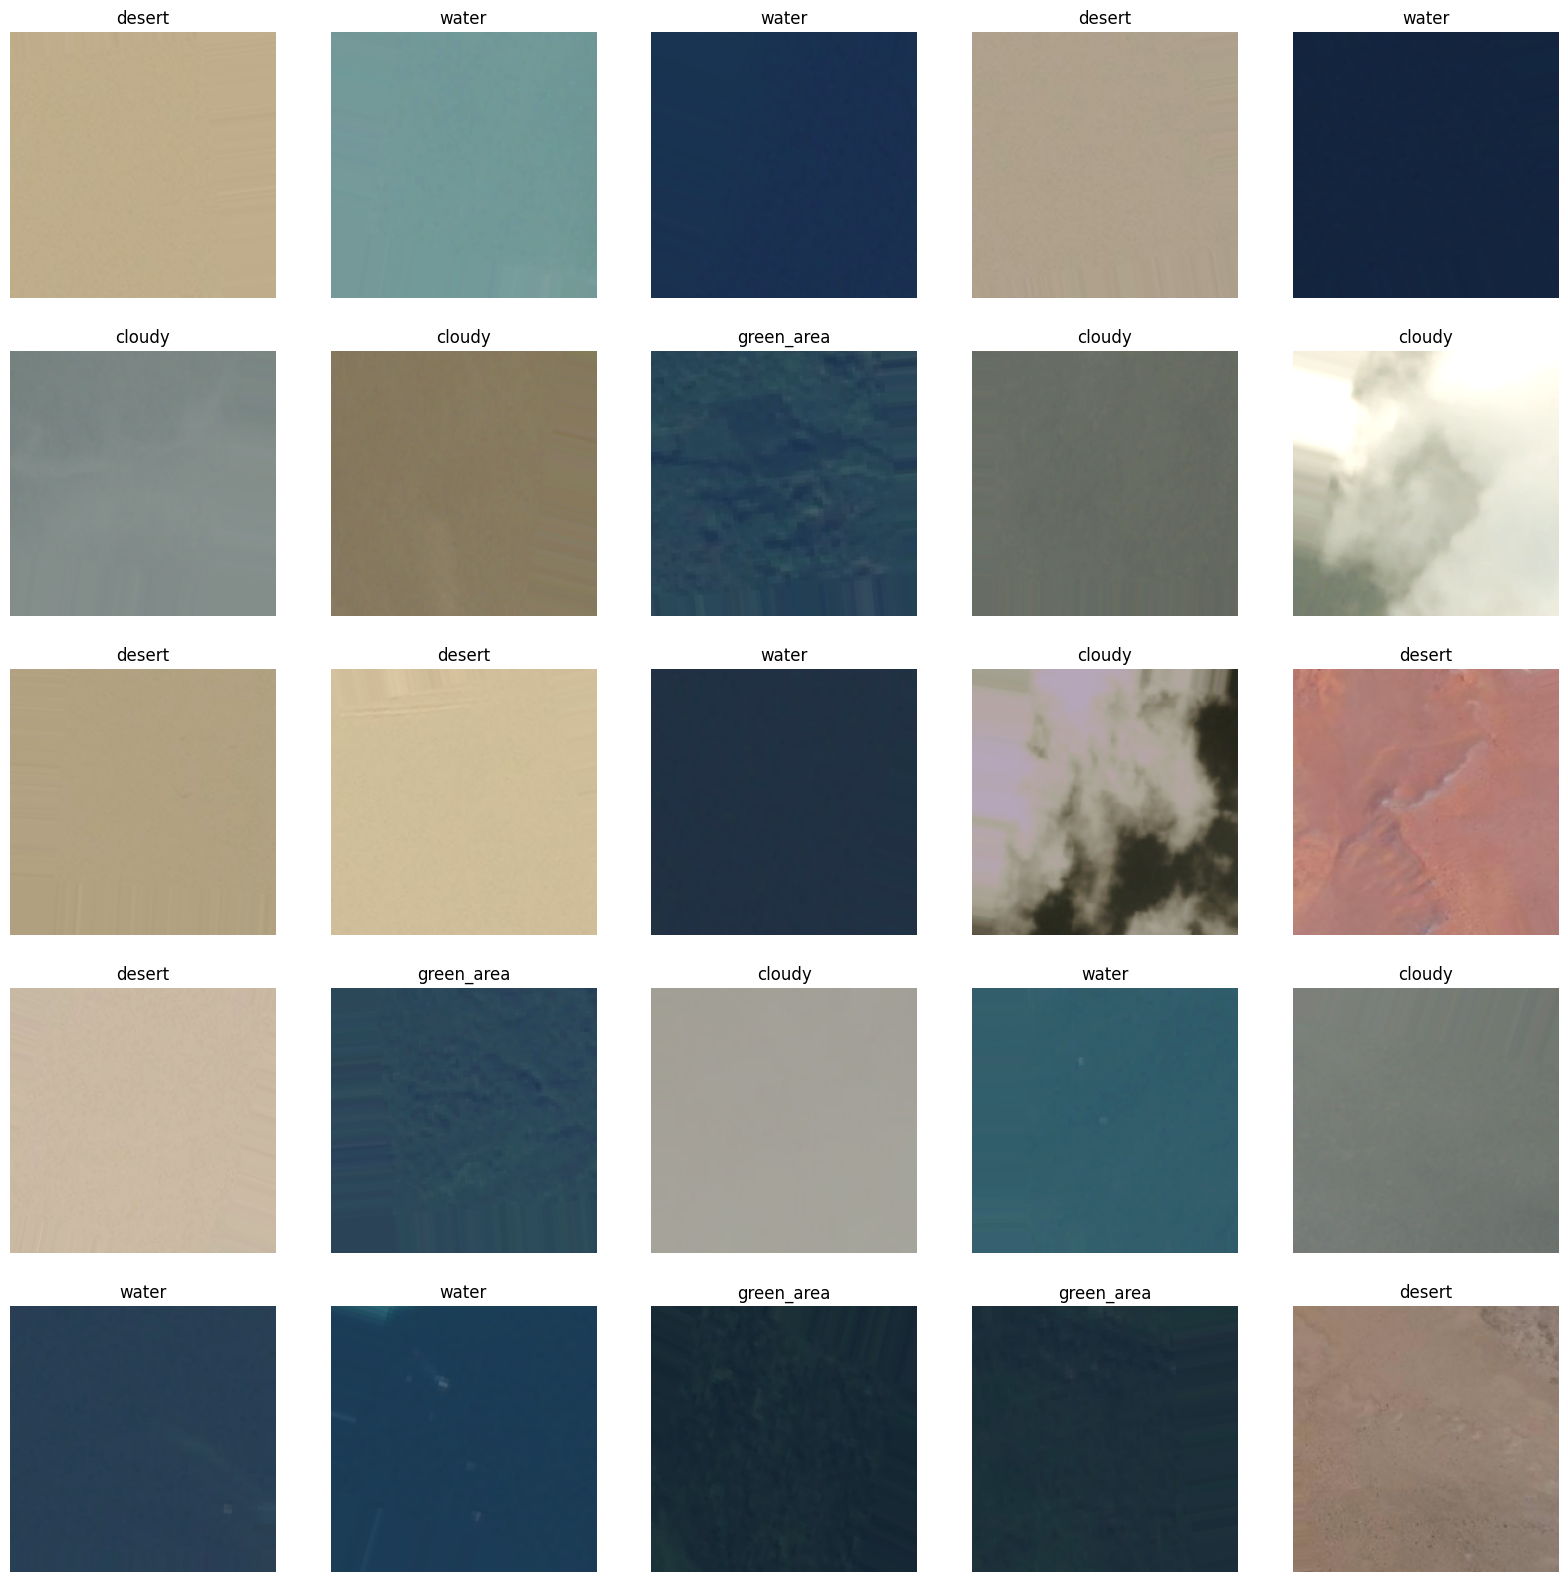

In [20]:
show_images(train_gen)

## Model Building

In [7]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False

I0000 00:00:1739119136.278499   16293 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4148 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [8]:
model = Sequential([

    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
     Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')

])

In [9]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,199,859 (42.72 MB)

 Trainable params: 413,252 (1.58 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

In [11]:
history = model.fit(
    x=train_gen,
    epochs=10,
    verbose=1,
    validation_data=valid_gen,
)

Epoch 1/10


I0000 00:00:1739119147.894419   16782 service.cc:148] XLA service 0x797d64004360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739119147.894437   16782 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-02-09 22:09:08.315289: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739119149.988389   16782 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/113 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.3819 - loss: 1.9419 

I0000 00:00:1739119164.291878   16782 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 284ms/step - accuracy: 0.8184 - loss: 0.5314 - val_accuracy: 0.9716 - val_loss: 0.0576
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9519 - loss: 0.1425 - val_accuracy: 0.9734 - val_loss: 0.0628
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9608 - loss: 0.0986 - val_accuracy: 0.9876 - val_loss: 0.0371
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9606 - loss: 0.1101 - val_accuracy: 0.9805 - val_loss: 0.0457
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9683 - loss: 0.1052 - val_accuracy: 0.9805 - val_loss: 0.0548
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9734 - loss: 0.0884 - val_accuracy: 0.9805 - val_loss: 0.0466
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9708 - loss: 0.1015 - val_accuracy: 0.9858 - val_loss: 0.0411
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9785 - loss: 0.0686 - val_accuracy: 0.9

## Model Evaluation

In [12]:
history_df = pd.DataFrame(history.history)
history_df

,accuracy,loss,val_accuracy,val_loss
0,0.893650,0.316863,0.971631,0.057589
1,0.951377,0.146779,0.973404,0.062847
2,0.961812,0.115991,0.987589,0.037133
3,0.963810,0.107861,0.980496,0.045698
4,0.964254,0.112760,0.980496,0.054848
5,0.976687,0.072548,0.980496,0.046578
6,0.971581,0.090465,0.985816,0.041122
7,0.977353,0.070480,0.982270,0.048799
8,0.975355,0.067033,0.984043,0.038083
9,0.975133,0.065864,0.989362,0.031143


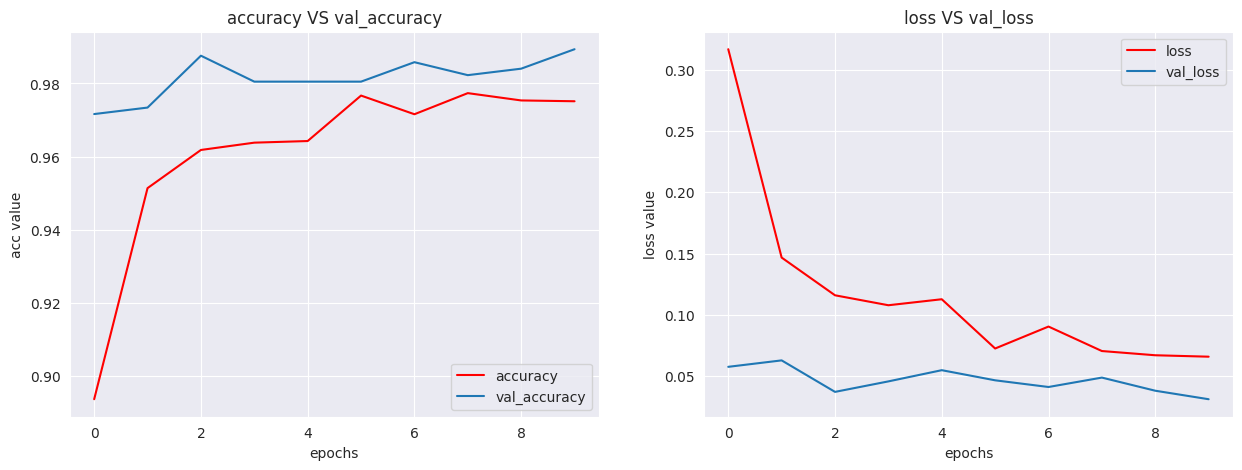

In [13]:
plt.figure(figsize=(15,5))

# plotting accuracy and val_accuracy
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'],label='accuracy',c='red')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('acc value')
plt.title('accuracy VS val_accuracy')
plt.legend()

# plotting loss and val_loss
plt.subplot(1,2,2)
plt.plot(history_df['loss'],label='loss',c='red')
plt.plot(history_df['val_loss'],label='val_loss')
plt.title('loss VS val_loss')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()

plt.show()